# Models 
First with torch

Later from scratch

## Model with Torch

In [108]:
# initialize libs
%pylab inline
import numpy as np
from tqdm import trange
from tqdm.auto import trange
np.set_printoptions(suppress=True)

# torch libs
import torch
import torch.nn as nn 
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)

# load data libs
import requests
import gzip
import os
import hashlib


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/erirosv/Library/Python/3.9/lib/python/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [109]:
# getting the data to train the model

def get_data(url):
    file_path = os.path.join('/tmp', hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(file_path):
        with open (file_path, 'rb') as f:
            data = f.read()
    else:
        with open(file_path, 'wb') as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype = np.uint8).copy()

In [110]:
x_train = get_data("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_train = get_data("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
x_test = get_data("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_test = get_data("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

### Model

In [111]:
class ApexNet(torch.nn.Module):
    def __init__(self) -> None:
        """
        Initialize class with an constructor and parameters
        """
        super(ApexNet, self).__init__()
        self.linear_1 = nn.Linear(784, 128, bias=False)
        self.linear_2 = nn.Linear(128, 10, bias=False)
        self.soft_max = nn.LogSoftmax(dim=1)

    def forward(self, x):
        """
        Forward pass for the model
        """
        x = F.relu(self.linear_1(x))
        x = self.linear_2(x)
        s = self.soft_max(x)
        return x

### Training

loss 0.208 accuracy 0.945: 100%|██████████| 1000/1000 [00:01<00:00, 958.53it/s]


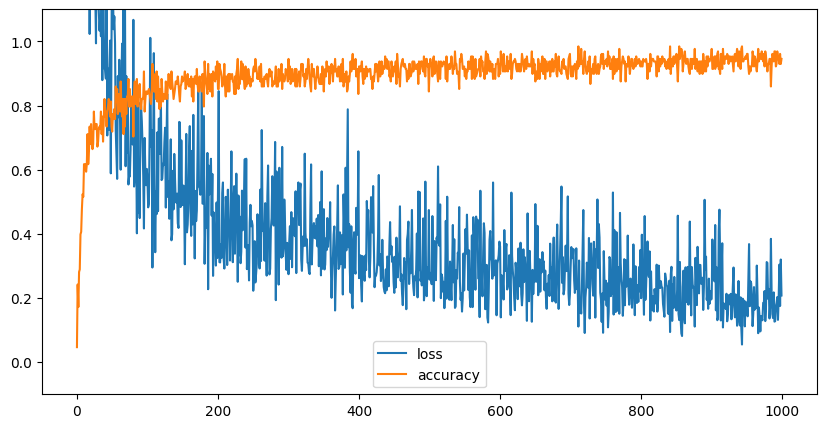

In [112]:
# Define the model, loss function, and optimizer
model = ApexNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)

# Set the batch size and create empty lists to store loss and accuracy values
batch_size = 128
losses = []
accuracies = []

# Train the model
from tqdm.auto import trange
t = trange(1000)
for i in t:
    # Create a random sample of integers
    sample = np.random.randint(0, x_train.shape[0], size=(batch_size))
    
    # Load the data into variables X and Y
    X = torch.tensor(x_train[sample].reshape((-1, 28*28))).float()
    Y = torch.tensor(y_train[sample]).long()
    
    # Reset gradients
    model.zero_grad()
    
    # Get model output and predicted classes
    out = model(X)
    cat = torch.argmax(out, dim=1)

    # Calculate accuracy and loss
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss = loss.mean()
    
    # Backpropagate the loss and update the weights
    loss.backward()
    optimizer.step()

    # Append the loss and accuracy values to their respective lists
    losses.append(loss.item())
    accuracies.append(accuracy.item())

    # Update the progress bar
    t.set_description("loss %.3f accuracy %.3f" % (loss, accuracy))
    
# Plot the loss and accuracy over time
figsize(10,5)
plt.ylim(-0.1, 1.1)
plot(losses, label='loss')
plot(accuracies, label='accuracy')
plt.legend()
plt.show()


### Evaluation

In [113]:
Y_test_predictions = torch.argmax(model(torch.tensor(x_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(y_test == Y_test_predictions).mean()

0.9303

### Breakdown of gradients 

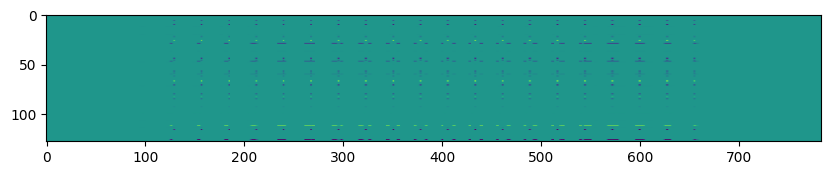

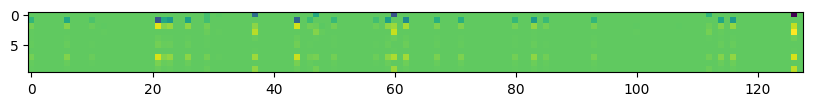

In [114]:
samp = [1,2,3,]
model.zero_grad()
out = model(torch.tensor(x_test[samp].reshape((-1, 28*28))).float())
out.retain_grad()

loss = loss_funtion(out, torch.tensor(y_test[samp]).long()).mean()
loss.backward()

imshow(model.linear_1.weight.grad)
figure()
imshow(model.linear_2.weight.grad)

## Model from scratch here

In [115]:
# making the sam layer from torch with numpy
layer_1 = np.zeros((784, 128), dtype=np.float32)
layer_2 = np.zeros((128, 10), dtype=np.float32)

# checking the types
(layer_1.dtype, layer_2.dtype)

(dtype('float32'), dtype('float32'))

In [116]:
# checking memory address for layer_1 and layer_2
(id(layer_1), id(layer_2))

(6254571312, 6057838224)

In [117]:
# used stupid name for layer in torch model
# copy weight from torch model
layer_1[:] = model.linear_1.weight.detach().numpy().T
layer_2[:] = model.linear_2.weight.detach().numpy().T

In [118]:
# forward-pass in numpy
def forward(x):
    x = x.dot(layer_1)
    x = np.maximum(x, 0)
    x = x.dot(layer_2)
    return x

In [119]:
Y_test_predictions_out = forward(x_test.reshape((-1, 28*28)))
Y_test_predictions = np.argmax(Y_test_predictions_out, axis=1)
(y_test == Y_test_predictions).mean()

0.9303

### Training (numpy)

In [120]:
#ret = (-np.array([Y_test_predictions_out[i, y_test[i]] for i in range(Y_test_predictions_out.shape[0])]) 
#       + np.log(np.exp(Y_test_predictions_out).sum(axis=1)))

ret = (-Y_test_predictions_out[range(Y_test_predictions_out.shape[0]), y_test] 
       + np.log(np.exp(Y_test_predictions_out).sum(axis=1)))

#plot(ret)

In [121]:
#np.gradient()

In [122]:
# test show classified img
#imshow(x_test[3508])

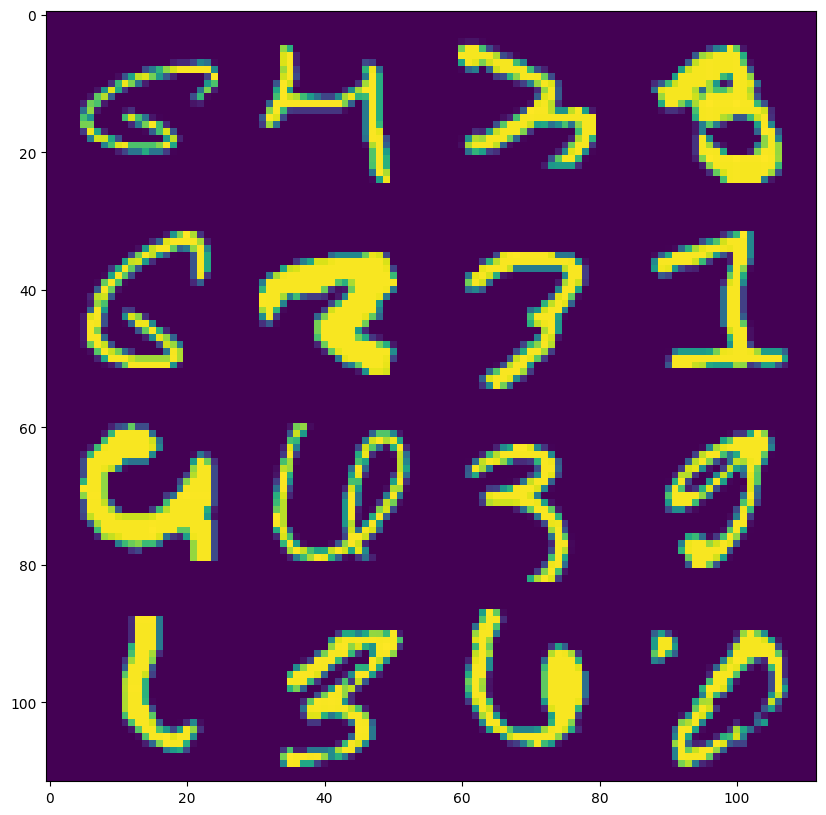

In [123]:
# grid
grid_var = 4
grid = sorted(list(zip(ret, range(ret.shape[0]))), reverse=True)[0:grid_var*grid_var]
temp = x_test[[x[1] for x in grid]]

figsize(10,10)
imshow(np.concatenate(temp.reshape((grid_var, 28*grid_var, 28)), axis=1))

In [124]:
sample = 1
-Y_test_predictions_out[sample, y_test[0]] + np.log(np.exp(Y_test_predictions_out[sample]).sum())

34.25785

In [125]:
-np.array([Y_test_predictions_out[i, y_test[i]] for i in range(Y_test_predictions_out.shape[0])]) + np.log(np.exp(Y_test_predictions_out).sum(axis=1))

array([0.        , 0.00000381, 0.00020313, ..., 0.04235649, 4.879382  ,
       0.00027084], dtype=float32)

In [126]:
Y_test_predictions_out[:, y_test].shape

(10000, 10000)

In [127]:
Y_test_predictions_out[y_test.reshape((1,-1))].shape

(1, 10000, 10)

In [128]:
np.array([Y_test_predictions_out[i, y_test[i]] for i in range(Y_test_predictions_out.shape[0])])

array([24.100645, 20.72829 , 13.649532, ..., 12.275909,  4.06052 ,
       21.93495 ], dtype=float32)

(1, 784) (1, 128) (1, 128) (1, 10)
(128, 10) (1, 128)


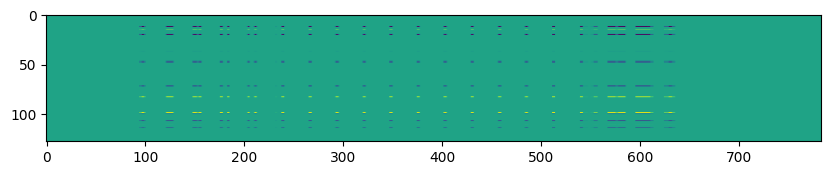

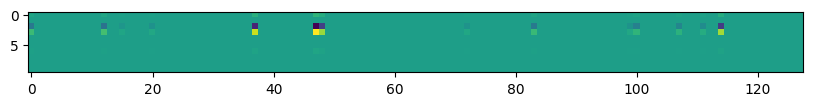

In [129]:
# forward pass
x = x_test[1:2].reshape((-1, 28*28))
x_layer_1 = x.dot(layer_1)
x_relu = np.maximum(x_layer_1, 0)
x_layer_2 = x_relu.dot(layer_2)
# check the shapes of the layers
print(x.shape, x_layer_1.shape, x_relu.shape, x_layer_2.shape)

# backward pass (testing)
out = np.zeros((1,10), np.float32)
out[0,2] = 1
#out = torch.tensor(out)

# derivated: log_softmax
#gradient_in = torch.tensor(Y_test_predictions_out[1], requires_grad=True)
out = torch.tensor(out)
gradient_in = torch.tensor(x_layer_2, requires_grad=True)
gradient_out = torch.nn.functional.log_softmax(gradient_in, dim=1)
loss = (-out * gradient_out).mean()
loss.backward()
dx_sm = gradient_in.grad.numpy()

# derivated (d): linera_2
d_layer2 = x_relu.T.dot(dx_sm)
dx_relu = dx_sm.dot(layer_2.T)

# derivate: ReLu (chainrule)
dx_layer1 = (x_relu > 0).astype(np.float32) * dx_relu

#derivate: layer 1
d_layer1 = x.T.dot(dx_layer1)

print(d_layer2.shape, dx_relu.shape)
imshow(d_layer1.T)
figure()
imshow(d_layer2.T)


In [130]:
(dx_relu > 0).astype(np.float32)

array([[0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
        0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
        0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
        0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.]],
      dtype=float32)